In [1]:
import pandas as pd
import os
import numpy as np
import re
import matplotlib.pyplot as plt

In [2]:
# Arbeitsverzeichnis ändern 
#neues_verzeichnis = "c:\\Users\\lpres\\OneDrive - JGU\\WMDV\\WebMining"
neues_verzeichnis = "C:\\Users\\Lucian\\Desktop\\WebMining"
os.chdir(neues_verzeichnis)

# Überprüfen, ob das Verzeichnis geändert wurde
print("Neues Arbeitsverzeichnis:", os.getcwd())

Neues Arbeitsverzeichnis: C:\Users\Lucian\Desktop\WebMining


In [3]:
# Alle vorhandenen owned_games_x Dateien finden
owned_files = [f for f in os.listdir('.') if re.match(r'owned_games_\d+\.csv', f)]
owned_files.sort(key=lambda x: int(re.search(r'\d+', x).group()))

print(f"Vorhandene Dateien: {owned_files}")

if not owned_files:
    print("Keine Dateien im Format 'owned_games_x.csv' gefunden. Das Skript wird beendet.")

# Alle Dateien einlesen und in einem DataFrame speichern
pre_df = pd.DataFrame()  # Leerer DataFrame

for file in owned_files:
    file_df = pd.read_csv(file, dtype={
         "steam_64_id": str,
         "appid": "Int64",  
         "playtime_forever": "Int64",
         "playtime_2weeks": "Int64"
    })
    pre_df = pd.concat([pre_df, file_df], ignore_index=True)

print("alle Dateien eingelesen")
print(pre_df.shape)

Vorhandene Dateien: ['owned_games_1.csv', 'owned_games_2.csv', 'owned_games_3.csv', 'owned_games_4.csv', 'owned_games_5.csv', 'owned_games_6.csv', 'owned_games_7.csv', 'owned_games_8.csv', 'owned_games_9.csv']


C:\Users\Lucian\AppData\Local\Temp\ipykernel_17792\35310863.py:14: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  file_df = pd.read_csv(file, dtype={


alle Dateien eingelesen
(10245880, 6)


In [4]:
# Duplikate und "No Games" rausschmeißen
h_df = pre_df.drop_duplicates(keep="first")
h_df = h_df[h_df["name"] != "No Games"]
dropped_rows = pre_df.shape[0] - h_df.shape[0]
print(h_df.shape)
print(f"{dropped_rows} Duplikate wurden entfernt")

(5800632, 6)
4445248 Duplikate wurden entfernt


In [5]:
# Sortieren nach höchster Spielzeit und dann Duplikate entfernen. Falls steam_id mehrfach abgefragt wurde, sollen die einträge behalten werden, die am neuesten sind (max(playtime_forever))
df = h_df.sort_values(by="playtime_forever", ascending=False).drop_duplicates(subset=["steam_64_id", "name"], keep="first")

# Anzahl der entfernten Duplikate berechnen
dropped_rows = h_df.shape[0] - df.shape[0]

print(df.shape)
print(f"{dropped_rows} Duplikate wurden entfernt (behalten wurde die Zeile mit der höchsten Spielzeit pro Spieler-Spiel-Kombination).")

(5728321, 6)
72311 Duplikate wurden entfernt (behalten wurde die Zeile mit der höchsten Spielzeit pro Spieler-Spiel-Kombination).


In [7]:
# Datensatz reduzieren auf Spiele, die von mindestens 2500 Spielern gespielt werden
spiel_counts = df['name'].value_counts()
filtered_games = df[df['name'].isin(spiel_counts[spiel_counts >= 2500].index)]

dropped_rows = df.shape[0] - filtered_games.shape[0]
print(f"{dropped_rows} weitere Zeilen wurden entfernt")
print(filtered_games.shape)

4131019 weitere Zeilen wurden entfernt
(1597302, 6)


In [11]:
unique_players_per_game = filtered_games.groupby('name')['steam_64_id'].nunique()
unique_players_per_game = unique_players_per_game.sort_values(ascending=False)
unique_players_per_game

name
Counter-Strike 2         40475
Dota 2                   38240
PUBG: BATTLEGROUNDS      31645
Apex Legends             19979
Wallpaper Engine         19885
                         ...  
Saints Row: The Third     2531
Age of Wonders III        2521
PAYDAY: The Heist         2510
Liar's Bar                2510
Hogwarts Legacy           2500
Name: steam_64_id, Length: 296, dtype: int64

In [9]:
# Anzahl der einzigartigen Spiele
unique_spiel_counts = filtered_games["name"].value_counts()
unique_spiel_counts

name
Counter-Strike 2         40475
Dota 2                   38240
PUBG: BATTLEGROUNDS      31645
Apex Legends             19979
Wallpaper Engine         19885
                         ...  
Saints Row: The Third     2531
Age of Wonders III        2521
Liar's Bar                2510
PAYDAY: The Heist         2510
Hogwarts Legacy           2500
Name: count, Length: 296, dtype: int64

In [13]:
#Mit fitlered_games als df weiter
df = filtered_games

# Filter out rows where the playtime_forever is zero (i.e., players who haven't played the game)
df = df[df['playtime_forever'] > 0]

dropped_rows = filtered_games.shape[0] - df.shape[0]
print(f"{dropped_rows} Zeilen mit playtime_forever == 0 wurden entfernt")
print(df.shape)

531505 Zeilen mit playtime_forever == 0 wurden entfernt
(1065797, 6)


Die nächsten zwei Zellen sind dafür da, um zu erörtern, ob PCA sinnvoll ist, um besser zu clustern

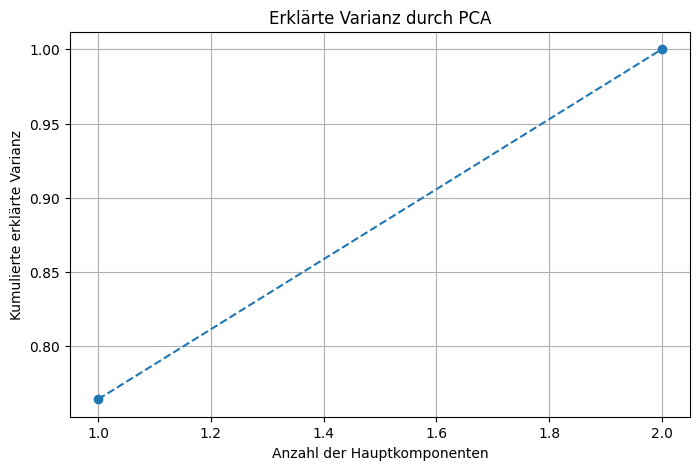

Anzahl der benötigten Hauptkomponenten für ~95% der Varianz: 2


In [17]:
#Prüfen ob PCA relevant ist

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Relevante numerische Features für PCA auswählen
numeric_features = ["playtime_forever", "playtime_2weeks"]

# Daten filtern: Nur numerische Spalten behalten und fehlende Werte entfernen
df_pca = df[numeric_features].dropna()

# Log-Transformation zur Normalisierung extremer Werte (optional)
df_pca = df_pca.replace(0, np.nan).dropna()  # Entferne Einträge mit 0 Spielzeit
df_pca = np.log1p(df_pca)  # log(1 + x), um extreme Werte zu reduzieren

# Standardisierung der Daten (wichtig für PCA)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pca)

# PCA durchführen
pca = PCA()
pca.fit(df_scaled)

# Kumulierte erklärte Varianz berechnen
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot der erklärten Varianz
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel("Anzahl der Hauptkomponenten")
plt.ylabel("Kumulierte erklärte Varianz")
plt.title("Erklärte Varianz durch PCA")
plt.grid()
plt.show()

# Prüfen, wie viele Hauptkomponenten mindestens 95 % der Varianz erklären
num_components = np.argmax(explained_variance >= 0.95) + 1

print(f"Anzahl der benötigten Hauptkomponenten für ~95% der Varianz: {num_components}")


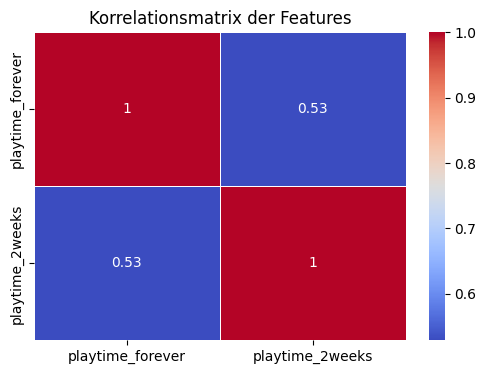

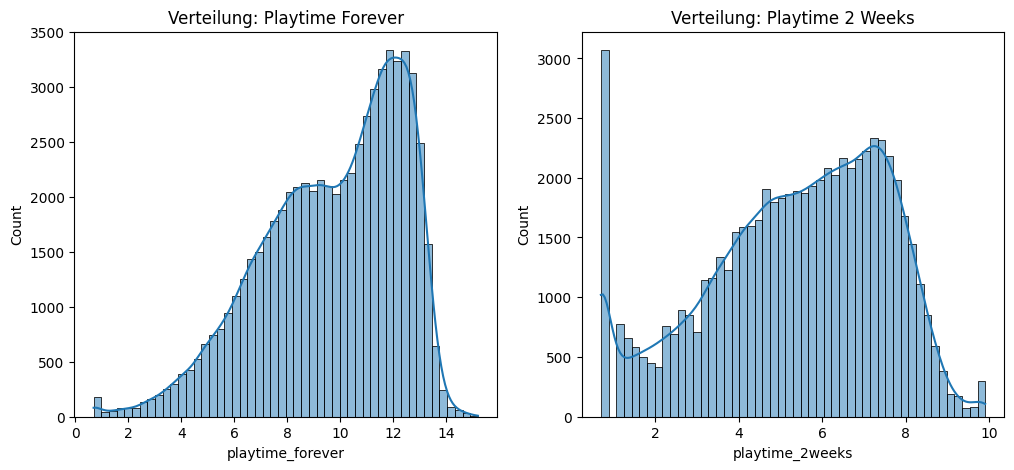

Silhouette-Score ohne PCA: 0.3609
Silhouette-Score mit PCA: 0.3609


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 1️⃣ Korrelation zwischen den Features prüfen
plt.figure(figsize=(6, 4))
sns.heatmap(df_pca.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Korrelationsmatrix der Features")
plt.show()

# 2️⃣ Verteilung der Features prüfen
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df_pca["playtime_forever"], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Verteilung: Playtime Forever")
sns.histplot(df_pca["playtime_2weeks"], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Verteilung: Playtime 2 Weeks")
plt.show()

# 3️⃣ Clustering testen mit und ohne PCA
# Ohne PCA
kmeans_original = KMeans(n_clusters=3, random_state=42)
clusters_original = kmeans_original.fit_predict(df_scaled)
silhouette_original = silhouette_score(df_scaled, clusters_original)

# Mit PCA
df_pca_transformed = pca.transform(df_scaled)[:, :2]  # Nur die ersten 2 Komponenten
kmeans_pca = KMeans(n_clusters=3, random_state=42)
clusters_pca = kmeans_pca.fit_predict(df_pca_transformed)
silhouette_pca = silhouette_score(df_pca_transformed, clusters_pca)

print(f"Silhouette-Score ohne PCA: {silhouette_original:.4f}")
print(f"Silhouette-Score mit PCA: {silhouette_pca:.4f}")


Fazit: PCA verbessert Clusterqualität nicht. Originaldaten verwenden

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Cluster-Anzahl von 2 bis 50 testen
wcss = []  # Summe der quadratischen Abstände (Elbow-Methode)
silhouette_scores = []

for k in range(2, 51):  # Testen bis zu 50 Cluster
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(df_scaled)
    
    wcss.append(kmeans.inertia_)  # Elbow-Kriterium
    silhouette_scores.append(silhouette_score(df_scaled, clusters))  # Silhouette-Score

# Elbow-Plot
plt.figure(figsize=(8, 4))
plt.plot(range(2, 51), wcss, marker='o', linestyle='--')
plt.xlabel("Anzahl der Cluster")
plt.ylabel("WCSS (Summe der quadratischen Abstände)")
plt.title("Elbow-Methode zur Bestimmung der Cluster-Anzahl")
plt.grid()
plt.show()

# Silhouette-Score-Plot
plt.figure(figsize=(8, 4))
plt.plot(range(2, 51), silhouette_scores, marker='o', linestyle='--', color='red')
plt.xlabel("Anzahl der Cluster")
plt.ylabel("Silhouette-Score")
plt.title("Silhouette-Score für verschiedene Cluster-Anzahlen")
plt.grid()
plt.show()

# Optimale Cluster-Anzahl ausgeben
optimal_k = np.argmax(silhouette_scores) + 2
print(f"Optimale Cluster-Anzahl: {optimal_k}")


KeyboardInterrupt: 